### Python数说指数定投

欢迎关注微信公众号：**python金融量化**（id:tkfy920），文章完整复刻代码可以加微信或qq群免费获取（公众号里点联系作者查看）。

### 基金定投
经管之家博主邢不行老师的文章：《【量化小讲堂-Python、Pandas系列13】数据告诉你：惊人的指数定投策略》  
巴菲特这一辈子曾经无数次的说过：对于个人投资者，最好的投资方式就是指数基金定投。

In [2]:
import tushare as ts
token='注册tushare pro获取token'
ts.set_token(token)
pro=ts.pro_api()

In [3]:
import pandas as pd  
import numpy as np
from scipy import stats
import tushare as ts 
import matplotlib.pyplot as plt
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
from datetime import datetime,timedelta
from pyecharts import *

In [43]:
#获取数据并计算对数收益率

def get_index_data(code):
    df=pd.DataFrame()
    df0=pro.index_daily(ts_code=code)
    df[code]=df0.close
    df.index=pd.to_datetime(df0.trade_date)
    df=df.sort_index()
    df['logret']=np.log(df/df.shift(1))
    return df.iloc[1:,:]

In [45]:
#A股常用的八个指数
common_index={'上证综指': '000001.SH',
              '深证成指': '399001.SZ',
              '沪深300': '000300.SH',
              '创业板指': '399006.SZ',
              '上证50': '000016.SH',
              '中证500': '000905.SH',
              '中小板指': '399005.SZ',
              '上证180': '000010.SH'}
#获取指数收盘价
index_data={}
for name,code in common_index.items():
    index_data[name]=get_index_data(code)
    

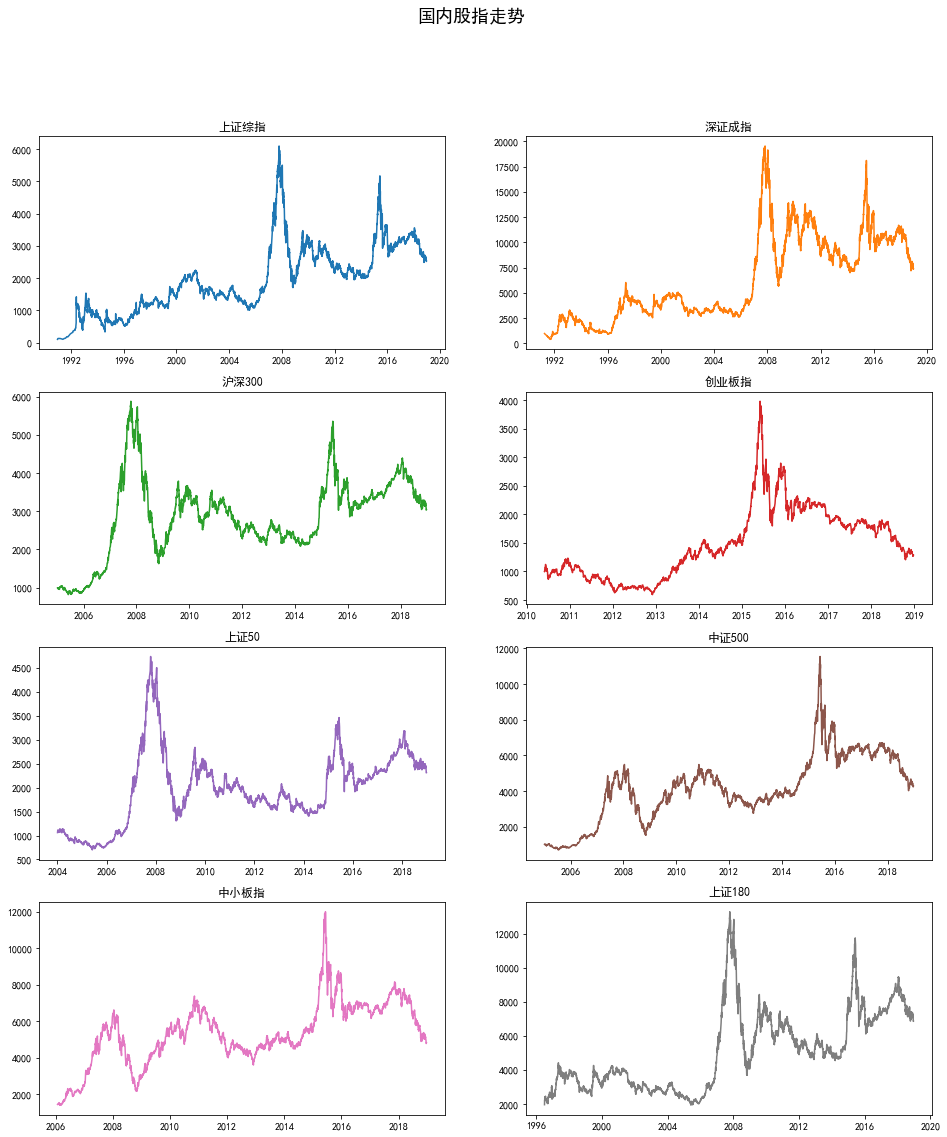

In [47]:
#对股价走势进行可视化
names =list(common_index.keys())
codes=list(common_index.values())

plot_pos = [421,422,423,424,425,426,427,428] # 每个子图的位置
new_colors = ['#1f77b4','#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f','#bcbd22','#17becf']

fig = plt.figure(figsize=(16,18))
fig.suptitle('国内股指走势',fontsize=18)
for i in np.arange(len(plot_pos)):       
    ax = fig.add_subplot(plot_pos[i]) 
    y_data =index_data[names[i]][codes[i]]  
    b = ax.plot(y_data,color=new_colors[i])   
    ax.set_title(names[i])    
plt.show()  

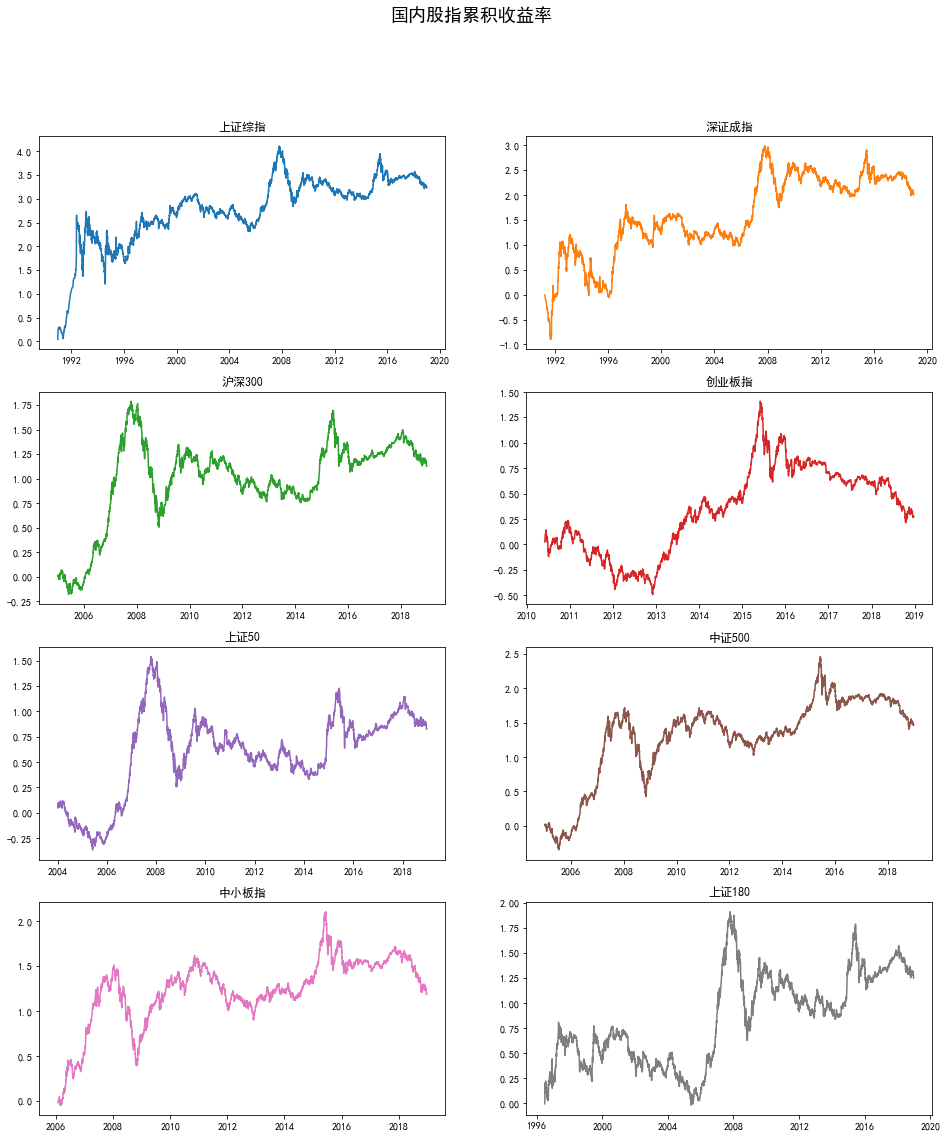

In [48]:
fig = plt.figure(figsize=(16,18))
fig.suptitle('国内股指累积收益率',fontsize=18)
for i in np.arange(len(plot_pos)):       
    ax = fig.add_subplot(plot_pos[i]) 
    y_data =index_data[names[i]]['logret'].cumsum()  
    b = ax.plot(y_data,color=new_colors[i])   
    ax.set_title(names[i])    
plt.show() 

In [76]:
def cum_return(start_date,end_date='2018-12-24'):
    df=pd.DataFrame()
    for name,data in index_data.items():
        df[name]=data.loc[start_date:end_date]['logret'].cumsum()
    return df

In [78]:
cum_return('1990-12-25').iloc[-1]

上证综指     3.093780
深证成指     2.012496
沪深300    1.128620
创业板指     0.277371
上证50     0.825632
中证500    1.465878
中小板指     1.193080
上证180    1.249210
Name: 2018-12-24 00:00:00, dtype: float64

In [77]:
cum_return('2018-01-01').iloc[-1]

上证综指    -0.269058
深证成指    -0.401092
沪深300   -0.282714
创业板指    -0.310891
上证50    -0.214059
中证500   -0.379994
中小板指    -0.451225
上证180   -0.231660
Name: 2018-12-24 00:00:00, dtype: float64

In [ ]:
cum_return('2018-01-01')

In [59]:
def plot_date_return(start_date,end_date='2018-12-24'):
    plt.figure(figsize=(16,6))
    plt.title('国内股指累积收益率',fontsize=18)
    for name,data in index_data.items():       
        data.loc[start_date:end_date,'logret'].cumsum().plot(label=name)
    plt.legend(loc=0)
    plt.show()    

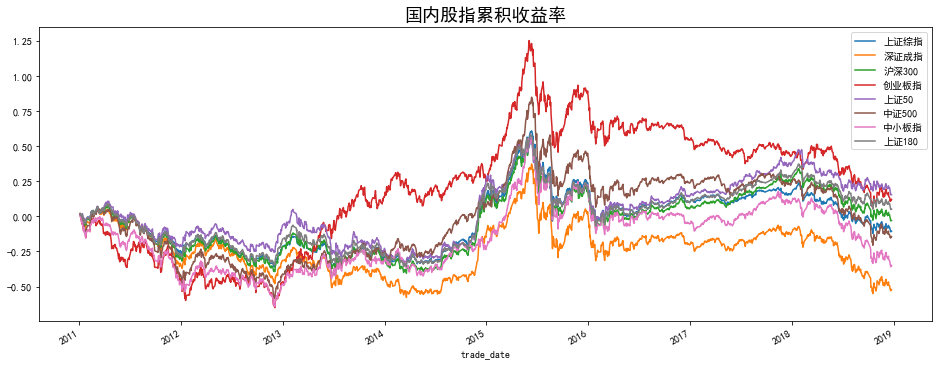

In [60]:
plot_date_return('2011-01-01')

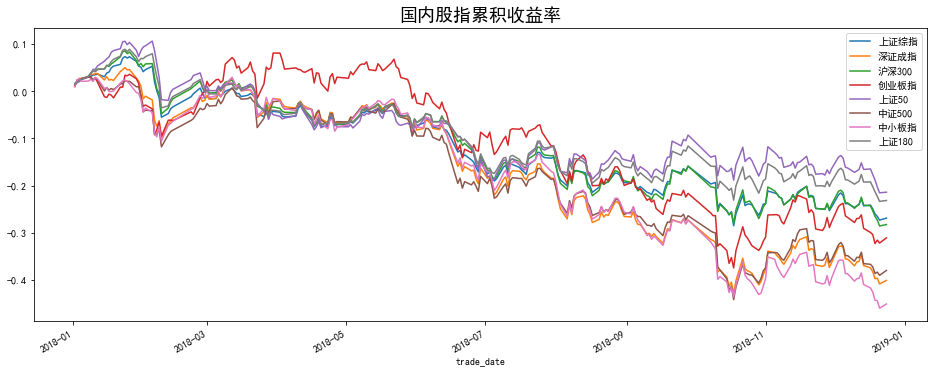

In [61]:
plot_date_return('2018-01-01')

In [1]:
### 指数定投评估函数

#指数定投函数
def index_strategy(code,start_date,end_date,first=1):

    ##步骤一：获取数据
    ##通过自定义函数get_index_data获取指数数据
    df=get_index_data(code)
    df=df.loc[start_date:end_date]
    #累计收益率
    df['累计收益率']=df.logret.cumsum()
    #假设定投无风险理财产品收益率为4%
    df['无风险收益率']=(4.0/100+1)**(1.0/250)-1
    df['无风险收益_净值']=(df['无风险收益率']+1).cumprod()
    
    ##步骤二：设定定投日并计算份额和累计资金
    #每月第一个交易日或最后一个交易日定投
    #first==1表示每个月第一个交易日定投
    if first==1:
        by_month=df.resample('M',kind='period').first()
    else:
        by_month=df.resample('M',kind='period').last()
    #定投购买指数基金
    trade_log=pd.DataFrame(index=by_month.index)
    #假设每月投入3000元
    trade_log['基金净值']=by_month[code]/3000
    trade_log['money']=3000 
    trade_log['基金份额']=trade_log['money']/trade_log['基金净值']
    trade_log['总基金份额']=trade_log['基金份额'].cumsum()
    trade_log['累计定投资金']=trade_log['money'].cumsum()
    
    ##步骤三：计算定投保本理财份额和资金
    trade_log['理财份额']=trade_log['money']/by_month['无风险收益_净值']
    trade_log['总理财份额']=trade_log['理财份额'].cumsum()
    temp=trade_log.resample('D').ffill()
    df=df.to_period('D')
    
    ##步骤三：计算每个交易日的资产（等于每天的基金份额乘以单位基金净值）和累计收益率
    daily_data=pd.concat([df,temp[['总基金份额','总理财份额','累计定投资金']]],axis=1,join='inner')
    daily_data['指数定投资金']=daily_data[code]/3000*daily_data['总基金份额']
    daily_data['理财定投资金']=daily_data['无风险收益_净值']*daily_data['总理财份额']
    daily_data['指数定投收益率']=(daily_data['指数定投资金']-daily_data['累计定投资金'])/daily_data['累计定投资金']
    daily_data['理财定投收益率']=(daily_data['理财定投资金']-daily_data['累计定投资金'])/daily_data['累计定投资金']
    
    #返回后面分析需要的变量
    return daily_data[[code,'累计收益率','累计定投资金','指数定投资金','理财定投资金','指数定投收益率','理财定投收益率']]